In [ ]:
!nvidia-smi

Sat Jul 22 11:34:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

1854.603271484375
[0 1 2 4]
[0 1 2 3]


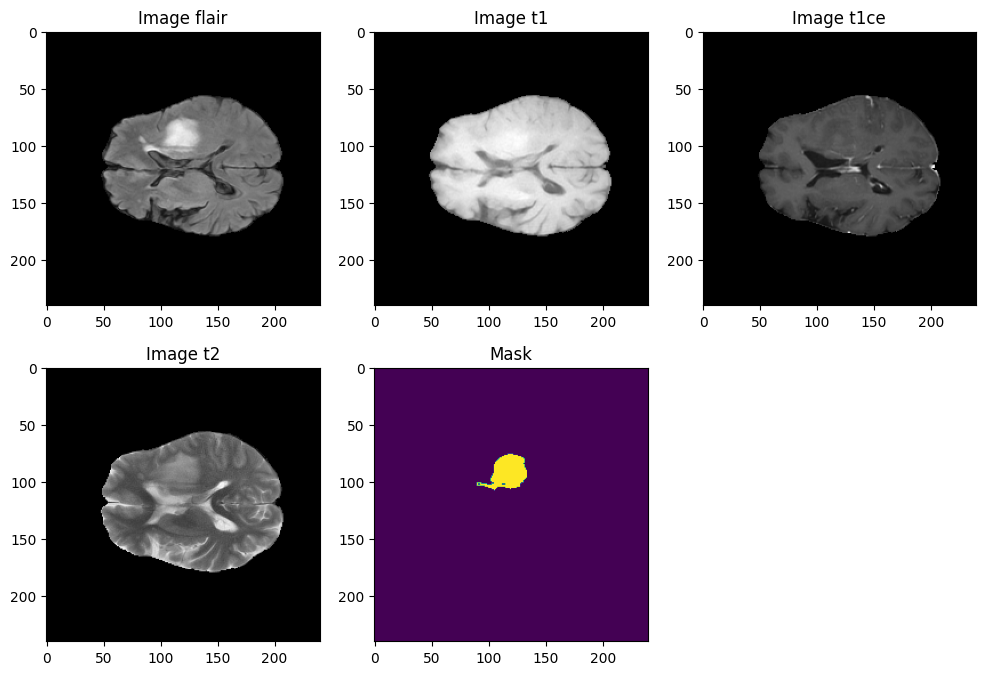

In [ ]:
TRAIN_DATASET_PATH = '/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
#VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_flair.nii').get_fdata()
print(test_image_flair.max())
#Scalers are applied to 1D so let us reshape and then reshape back to original shape.
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)


test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask))

import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


In [ ]:
combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

#Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches.
#cropping x, y, and z
#combined_x=combined_x[24:216, 24:216, 13:141]

combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4

#Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]

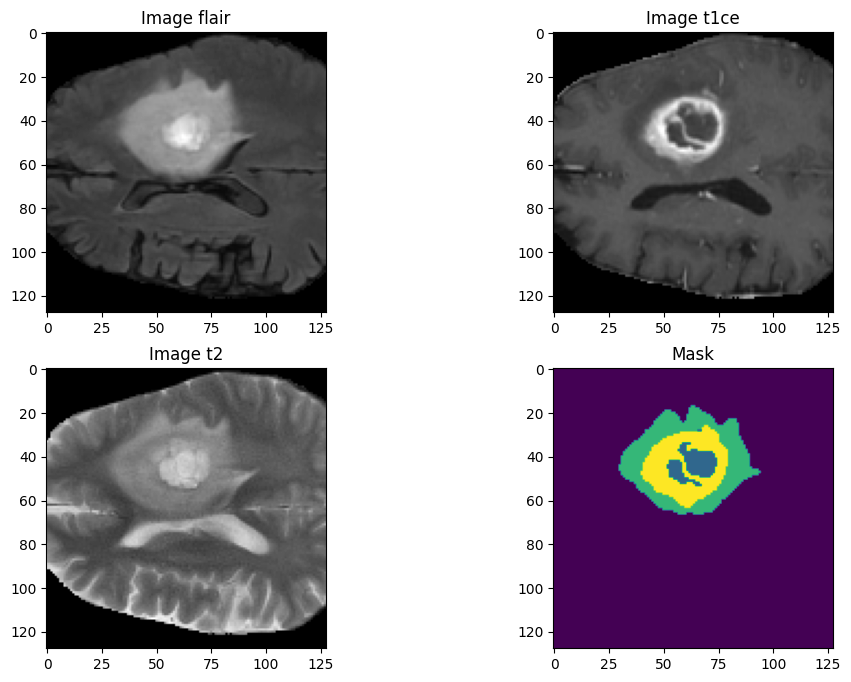

In [ ]:
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


In [ ]:
imsave('/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/combined255.tif', combined_x)
np.save('/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/combined255.npy', combined_x)

<ipython-input-7-cf1ae4b881e9>:1: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave('/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/combined255.tif', combined_x)


In [ ]:
my_img=np.load('/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/combined255.npy')

test_mask = to_categorical(test_mask, num_classes=4)

In [ ]:
t2_list = sorted(glob.glob('/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list = sorted(glob.glob('/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob.glob('/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list = sorted(glob.glob('/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))

In [ ]:
for img in range(len(t2_list)):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)

    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    #print(np.unique(temp_mask))


    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)

    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches.
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]

    val, counts = np.unique(temp_mask, return_counts=True)

    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save('/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/input_data_3channels/images/image_'+str(img)+'.npy', temp_combined_images)
        np.save('/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/input_data_3channels/masks/mask_'+str(img)+'.npy', temp_mask)

    else:
        print("don`t save")


Now preparing image and masks number:  0
Save Me
Now preparing image and masks number:  1
Save Me
Now preparing image and masks number:  2
Save Me
Now preparing image and masks number:  3
Save Me
Now preparing image and masks number:  4
don`t save
Now preparing image and masks number:  5
Save Me
Now preparing image and masks number:  6
Save Me
Now preparing image and masks number:  7
Save Me
Now preparing image and masks number:  8
Save Me
Now preparing image and masks number:  9
Save Me
Now preparing image and masks number:  10
Save Me
Now preparing image and masks number:  11
Save Me
Now preparing image and masks number:  12
Save Me
Now preparing image and masks number:  13
Save Me
Now preparing image and masks number:  14
Save Me
Now preparing image and masks number:  15
Save Me
Now preparing image and masks number:  16
Save Me
Now preparing image and masks number:  17
Save Me
Now preparing image and masks number:  18
Save Me
Now preparing image and masks number:  19
Save Me
Now pre

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders  # or import split_folders

input_folder = '/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/input_data_3channels/'
output_folder = '/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/input_data_128/'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values


Copying files: 0 files [00:00, ? files/s]
Copying files: 1 files [00:00,  9.79 files/s]
Copying files: 2 files [00:00,  4.27 files/s]
Copying files: 3 files [00:00,  3.71 files/s]
Copying files: 4 files [00:01,  3.33 files/s]
Copying files: 5 files [00:02,  1.80 files/s]
Copying files: 6 files [00:03,  1.36 files/s]
Copying files: 7 files [00:03,  1.53 files/s]
Copying files: 8 files [00:04,  1.77 files/s]
Copying files: 9 files [00:04,  2.03 files/s]
Copying files: 10 files [00:05,  1.47 files/s]
Copying files: 11 files [00:07,  1.05s/ files]
Copying files: 12 files [00:08,  1.02 files/s]
Copying files: 13 files [00:09,  1.01 files/s]
Copying files: 14 files [00:13,  1.93s/ files]
Copying files: 15 files [00:15,  1.87s/ files]
Copying files: 16 files [00:15,  1.47s/ files]
Copying files: 17 files [00:16,  1.40s/ files]
Copying files: 18 files [00:17,  1.08s/ files]
Copying files: 19 files [00:17,  1.14 files/s]
Copying files: 20 files [00:19,  1.34s/ files]
Copying files: 21 files [0

In [4]:
import os
import numpy as np


def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'npy'):

            image = np.load(img_dir+image_name)

            images.append(image)
    images = np.array(images)

    return(images)




def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size

In [ ]:
from matplotlib import pyplot as plt
import random

train_img_dir = "/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/input_data_128/train/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)


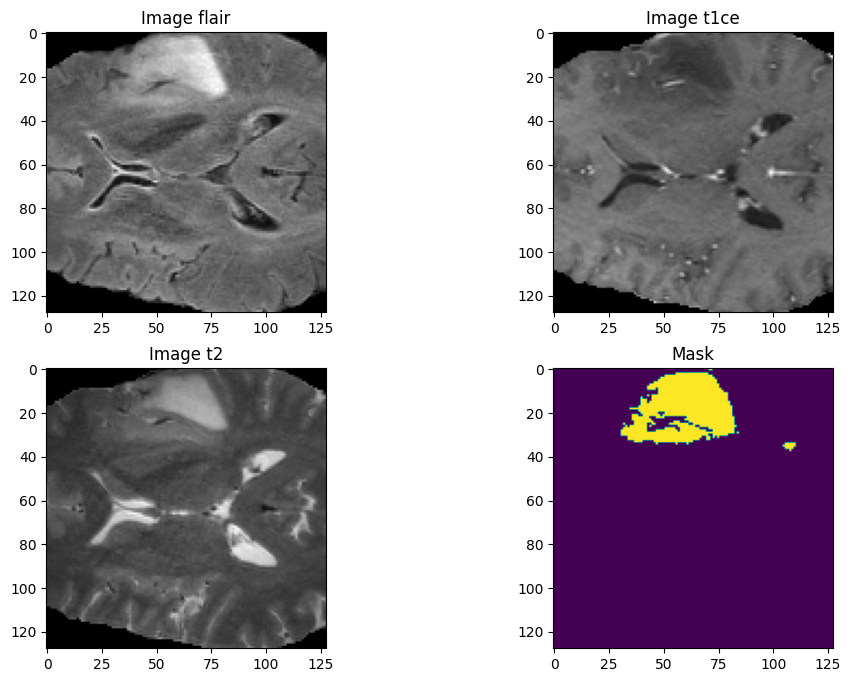

In [ ]:
img, msk = train_img_datagen.__next__()


img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [5]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform'


################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible.
    model.summary()

    return model

#Test if everything is working ok.
model = simple_unet_model(128, 128, 128, 3, 4)
print(model.input_shape)
print(model.output_shape)

ValueError: Exception encountered when calling layer "max_pooling3d_1" (type MaxPooling3D).

Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling3d_1/MaxPool3D}} = MaxPool3D[T=DT_FLOAT, data_format="NDHWC", ksize=[1, 2, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 2, 1]](max_pooling3d_1/transpose)' with input shapes: [?,64,64,1,32].

Call arguments received by layer "max_pooling3d_1" (type MaxPooling3D):
  • inputs=tf.Tensor(shape=(None, 32, 64, 64, 1), dtype=float32)

In [ ]:
import os
import numpy as np
#import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random


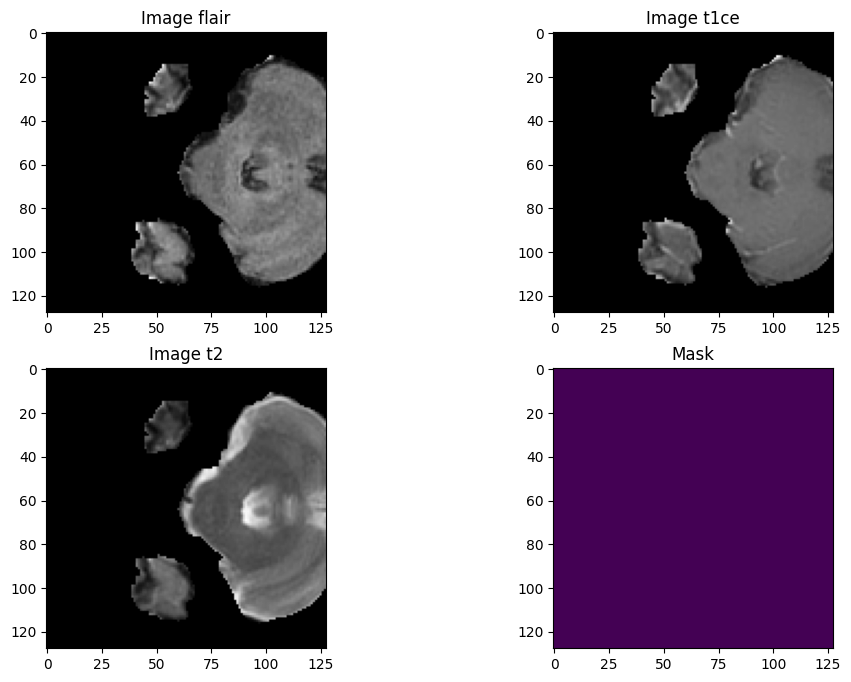

In [ ]:
train_img_dir = "/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/input_data_128/train/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:

import pandas as pd
columns = ['0','1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob('/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/input_data_128/train/masks/*.npy'))
for img in range(len(train_mask_list)):
    print(img)
    temp_image=np.load(train_mask_list[img])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    zipped = zip(columns, counts)
    conts_dict = dict(zipped)

    df = df.append(conts_dict, ignore_index=True)

label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['1'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4
#Class weights claculation: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
wt3 = round((total_labels/(n_classes*label_3)), 2)

0


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


1


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


2
3


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


4


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


5


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


6


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


7


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


8


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


9


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


10


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


11


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


12


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


13


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


14


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


15


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


16


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


17


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


18


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


19


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


20


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


21
22


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


23


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


24


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


25


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


26


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


27


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


28


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


29


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


30


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


31


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


32


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


33


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


34


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


35


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


36


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


37


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


38


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


39
40


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


41


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


42


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


43


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


44


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


45
46


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


47


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


48


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


49


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


50


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


51


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


52


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


53


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


54


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


55


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


56


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


57


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


58


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


59


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


60


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


61


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


62


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


63


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


64


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


65


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


66


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


67


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


68


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


69


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


70


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


71


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


72


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


73
74


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


75


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


76
77


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


78


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


79


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


80


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


81


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


82


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


83


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


84


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


85


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


86


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


87


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


88
89


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


90
91


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


92


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


93


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


94
95


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


96


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


97


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


98


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


99


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


100


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


101


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


102


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


103


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


104


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


105


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


106
107


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


108


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


109


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


110


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


111


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


112


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


113


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


114


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


115


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


116


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


117


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


118


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


119
120


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


121


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


122


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


123


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


124


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


125


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


126


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


127


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


128


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


129
130


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


131


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


132


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


133


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


134


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


135


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


136


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


137


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


138


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


139


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


140


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


141


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


142


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


143


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


144


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


145


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


146


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


147


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


148


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


149


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


150


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


151


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


152


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


153


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


154


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


155


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


156


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


157


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


158


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


159


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


160


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


161


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


162


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


163


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


164


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


165


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


166


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


167


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


168


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


169


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


170


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


171


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


172


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


173


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


174


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


175


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


176


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


177


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


178


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


179


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


180


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


181


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


182


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


183


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


184


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


185


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


186


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


187


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


188


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


189


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


190


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


191


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


192


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


193


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


194


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


195


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


196


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


197


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


198


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


199


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


200


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


201


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


202


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


203


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


204


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


205


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


206


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


207


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


208


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


209


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


210


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


211


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


212


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


213


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


214


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


215
216


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


217


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


218


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


219


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


220


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


221


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


222


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


223


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


224


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


225


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


226


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


227


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


228


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


229


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


230


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


231


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


232


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


233


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


234


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


235


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


236


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


237


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


238


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


239


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


240


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


241


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


242


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


243


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


244


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


245


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


246


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


247


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


248


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


249


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


250


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


251


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


252


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


253


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


254


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


255


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


256


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


257


<ipython-input-22-0ef6bc94a4ce>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


In [ ]:
train_img_dir = "/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/input_data_128/train/masks/"

val_img_dir = "/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/input_data_128/val/images/"
val_mask_dir = "/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/input_data_128/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [ ]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)


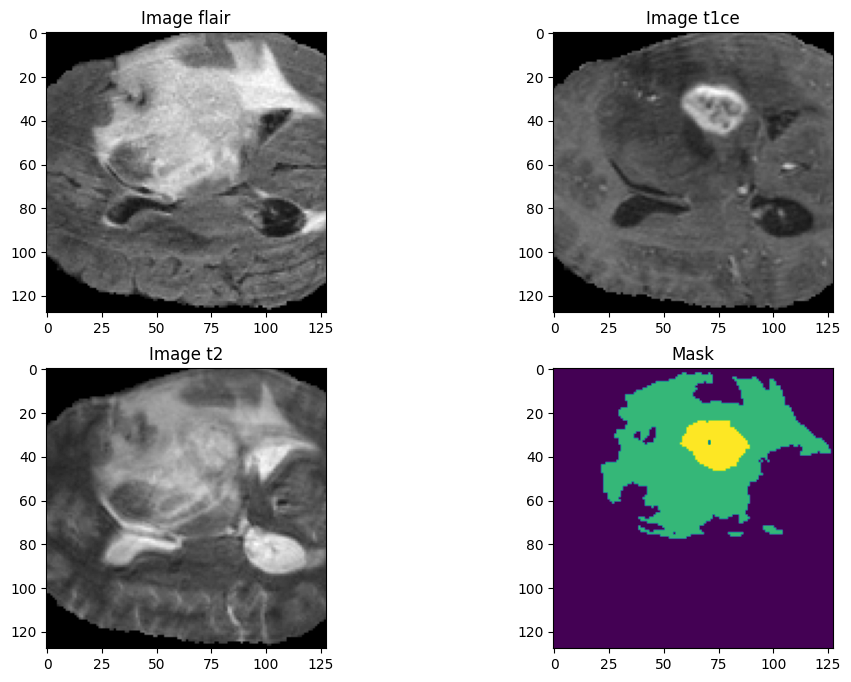

In [ ]:
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
print(wt0)

0.26


In [ ]:
!pip install segmentation_models_3D

In [ ]:
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

Segmentation Models: using `tf.keras` framework.


In [ ]:

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size


model = simple_unet_model(IMG_HEIGHT=128,
                          IMG_WIDTH=128,
                          IMG_DEPTH=128,
                          IMG_CHANNELS=3,
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_19 (Conv3D)             (None, 128, 128, 12  1312        ['input_2[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 12  0           ['conv3d_19[0][0]']              
                                8, 16)                                                      

In [ ]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

model.save('/content/drive/MyDrive/archive (11)/newbrats_3d.hdf5')

Epoch 1/10
129/129 [==============================] - 575s 4s/step - loss: 0.9606 - accuracy: 0.8740 - iou_score: 0.1918 - val_loss: 0.9512 - val_accuracy: 0.9503 - val_iou_score: 0.2028
Epoch 2/10
129/129 [==============================] - 497s 4s/step - loss: 0.9438 - accuracy: 0.9517 - iou_score: 0.2272 - val_loss: 0.9471 - val_accuracy: 0.9503 - val_iou_score: 0.2072
Epoch 3/10
129/129 [==============================] - 469s 4s/step - loss: 0.9421 - accuracy: 0.9517 - iou_score: 0.2274 - val_loss: 0.9419 - val_accuracy: 0.9503 - val_iou_score: 0.2406
Epoch 4/10
129/129 [==============================] - 468s 4s/step - loss: 0.9408 - accuracy: 0.9492 - iou_score: 0.2262 - val_loss: 0.9405 - val_accuracy: 0.9503 - val_iou_score: 0.2410
Epoch 5/10
129/129 [==============================] - 477s 4s/step - loss: 0.9393 - accuracy: 0.9478 - iou_score: 0.2325 - val_loss: 0.9392 - val_accuracy: 0.9503 - val_iou_score: 0.2432
Epoch 6/10
129/129 [==============================] - 493s 4s/ste

In [ ]:
history0=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

model.save('/content/drive/MyDrive/archive (11)/1_newbrats_3d.hdf5')

Epoch 1/10
129/129 [==============================] - 606s 5s/step - loss: 0.9579 - accuracy: 0.8697 - iou_score: 0.1984 - val_loss: 0.9546 - val_accuracy: 0.9502 - val_iou_score: 0.1756
Epoch 2/10
129/129 [==============================] - 540s 4s/step - loss: 0.9426 - accuracy: 0.9481 - iou_score: 0.2287 - val_loss: 0.9459 - val_accuracy: 0.9503 - val_iou_score: 0.2185
Epoch 3/10
129/129 [==============================] - 507s 4s/step - loss: 0.9406 - accuracy: 0.9400 - iou_score: 0.2301 - val_loss: 0.9447 - val_accuracy: 0.9506 - val_iou_score: 0.2196
Epoch 4/10
129/129 [==============================] - 509s 4s/step - loss: 0.9390 - accuracy: 0.9381 - iou_score: 0.2417 - val_loss: 0.9414 - val_accuracy: 0.9532 - val_iou_score: 0.2333
Epoch 5/10
129/129 [==============================] - 518s 4s/step - loss: 0.9370 - accuracy: 0.9401 - iou_score: 0.2485 - val_loss: 0.9394 - val_accuracy: 0.9535 - val_iou_score: 0.2469
Epoch 6/10
129/129 [==============================] - 490s 4s/ste

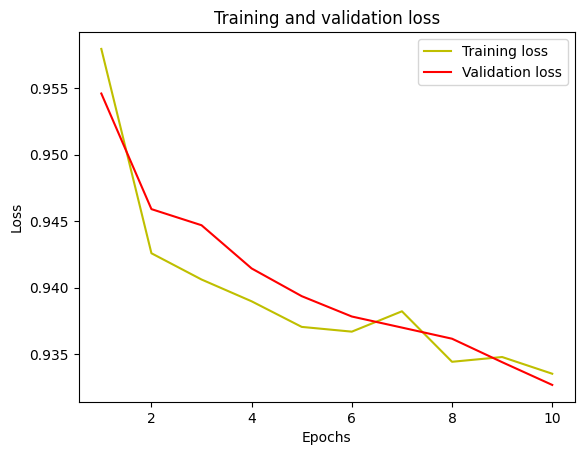

In [ ]:
loss = history0.history['loss']
val_loss = history0.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

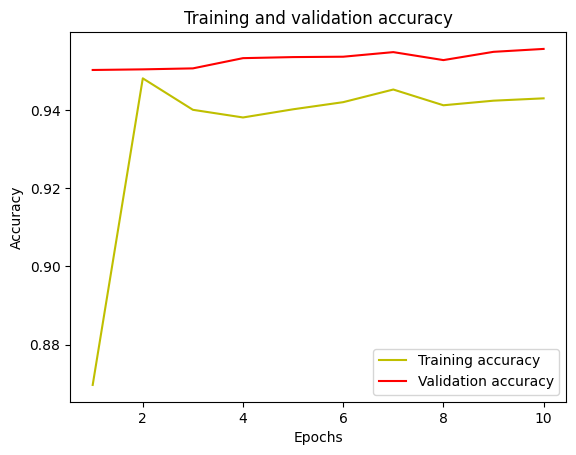

In [ ]:
acc = history0.history['accuracy']
val_acc = history0.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
my_modelc = load_model('/content/drive/MyDrive/archive (11)/1_newbrats_3d.hdf5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

#Now all set to continue the training process.
history_c=my_modelc.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=7,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )
my_modelc.save('/content/drive/MyDrive/archive (11)/cnew_newbrats_3d.hdf5')

Epoch 1/7
129/129 [==============================] - 711s 5s/step - loss: 0.9317 - accuracy: 0.9435 - iou_score: 0.2762 - val_loss: 0.9318 - val_accuracy: 0.9561 - val_iou_score: 0.2837
Epoch 2/7
129/129 [==============================] - 522s 4s/step - loss: 0.9314 - accuracy: 0.9412 - iou_score: 0.2730 - val_loss: 0.9303 - val_accuracy: 0.9565 - val_iou_score: 0.2873
Epoch 3/7
129/129 [==============================] - 618s 5s/step - loss: 0.9303 - accuracy: 0.9414 - iou_score: 0.2801 - val_loss: 0.9293 - val_accuracy: 0.9572 - val_iou_score: 0.2944
Epoch 4/7
129/129 [==============================] - 523s 4s/step - loss: 0.9295 - accuracy: 0.9401 - iou_score: 0.2770 - val_loss: 0.9274 - val_accuracy: 0.9571 - val_iou_score: 0.2953
Epoch 5/7
129/129 [==============================] - 510s 4s/step - loss: 0.9292 - accuracy: 0.9399 - iou_score: 0.2795 - val_loss: 0.9269 - val_accuracy: 0.9569 - val_iou_score: 0.2989
Epoch 6/7
129/129 [==============================] - 513s 4s/step - lo

In [ ]:
from keras.models import load_model
my_model = load_model('/content/drive/MyDrive/archive (11)/1_newbrats_3d.hdf5',
                      compile=False)

In [ ]:
from keras.models import load_model
my_modeld = load_model('/content/drive/MyDrive/archive (11)/cnew_newbrats_3d.hdf5',
                      compile=False)

In [ ]:
from keras.models import load_model
my_modeld = load_model('/content/drive/MyDrive/archive (11)/cnew_newbrats_3d.hdf5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

#Now all set to continue the training process.
history_d=my_modeld.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=7,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )
my_modeld.save('/content/drive/MyDrive/archive (11)/dnew_newbrats_3d.hdf5')

Epoch 1/7
129/129 [==============================] - 618s 5s/step - loss: 0.9302 - accuracy: 0.9403 - iou_score: 0.2841 - val_loss: 0.9265 - val_accuracy: 0.9574 - val_iou_score: 0.3104
Epoch 2/7
129/129 [==============================] - 649s 5s/step - loss: 0.9289 - accuracy: 0.9393 - iou_score: 0.2863 - val_loss: 0.9245 - val_accuracy: 0.9570 - val_iou_score: 0.3083
Epoch 3/7
129/129 [==============================] - 658s 5s/step - loss: 0.9274 - accuracy: 0.9374 - iou_score: 0.2876 - val_loss: 0.9227 - val_accuracy: 0.9578 - val_iou_score: 0.3114
Epoch 4/7
129/129 [==============================] - 699s 5s/step - loss: 0.9284 - accuracy: 0.9389 - iou_score: 0.2887 - val_loss: 0.9241 - val_accuracy: 0.9575 - val_iou_score: 0.3165
Epoch 5/7
129/129 [==============================] - 657s 5s/step - loss: 0.9275 - accuracy: 0.9397 - iou_score: 0.2892 - val_loss: 0.9235 - val_accuracy: 0.9573 - val_iou_score: 0.3164
Epoch 6/7
129/129 [==============================] - 649s 5s/step - lo

In [ ]:
from keras.models import load_model
my_modelf = load_model('/content/drive/MyDrive/archive (11)/dnew_newbrats_3d.hdf5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

#Now all set to continue the training process.
history_f=my_modelf.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=15,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )
my_modelf.save('/content/drive/MyDrive/archive (11)/fnew_newbrats_3d.hdf5')

Epoch 1/15
129/129 [==============================] - 534s 4s/step - loss: 0.9261 - accuracy: 0.9393 - iou_score: 0.2884 - val_loss: 0.9234 - val_accuracy: 0.9575 - val_iou_score: 0.3087
Epoch 2/15
129/129 [==============================] - 460s 4s/step - loss: 0.9245 - accuracy: 0.9354 - iou_score: 0.2898 - val_loss: 0.9216 - val_accuracy: 0.9577 - val_iou_score: 0.3103
Epoch 3/15
129/129 [==============================] - 467s 4s/step - loss: 0.9243 - accuracy: 0.9370 - iou_score: 0.2910 - val_loss: 0.9247 - val_accuracy: 0.9568 - val_iou_score: 0.3037
Epoch 4/15
129/129 [==============================] - 481s 4s/step - loss: 0.9249 - accuracy: 0.9368 - iou_score: 0.2936 - val_loss: 0.9265 - val_accuracy: 0.9562 - val_iou_score: 0.3013
Epoch 5/15
129/129 [==============================] - 462s 4s/step - loss: 0.9255 - accuracy: 0.9330 - iou_score: 0.2911 - val_loss: 0.9220 - val_accuracy: 0.9568 - val_iou_score: 0.3022
Epoch 6/15
129/129 [==============================] - 433s 3s/ste

In [ ]:
from keras.models import load_model
my_modelg = load_model('/content/drive/MyDrive/archive (11)/fnew_newbrats_3d.hdf5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

#Now all set to continue the training process.
history_g=my_modelg.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=6,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )
my_modelg.save('/content/drive/MyDrive/archive (11)/gnew_newbrats_3d.hdf5')

Epoch 1/6
129/129 [==============================] - 753s 6s/step - loss: 0.9078 - accuracy: 0.9309 - iou_score: 0.3591 - val_loss: 0.9144 - val_accuracy: 0.9571 - val_iou_score: 0.3499
Epoch 2/6
129/129 [==============================] - 819s 6s/step - loss: 0.9067 - accuracy: 0.9320 - iou_score: 0.3653 - val_loss: 0.9133 - val_accuracy: 0.9556 - val_iou_score: 0.3671
Epoch 3/6
129/129 [==============================] - 754s 6s/step - loss: 0.9071 - accuracy: 0.9327 - iou_score: 0.3652 - val_loss: 0.9160 - val_accuracy: 0.9549 - val_iou_score: 0.3740
Epoch 4/6
129/129 [==============================] - 761s 6s/step - loss: 0.9056 - accuracy: 0.9336 - iou_score: 0.3665 - val_loss: 0.9165 - val_accuracy: 0.9548 - val_iou_score: 0.3550
Epoch 5/6
129/129 [==============================] - 840s 7s/step - loss: 0.9041 - accuracy: 0.9330 - iou_score: 0.3729 - val_loss: 0.9124 - val_accuracy: 0.9540 - val_iou_score: 0.3866
Epoch 6/6
129/129 [==============================] - 808s 6s/step - lo

In [ ]:
from keras.models import load_model
my_modelh = load_model('/content/drive/MyDrive/archive (11)/gnew_newbrats_3d.hdf5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

#Now all set to continue the training process.
history_h=my_modelh.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=15,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )
my_modelh.save('/content/drive/MyDrive/archive (11)/hnew_newbrats_3d.hdf5')

Epoch 1/15
129/129 [==============================] - 581s 4s/step - loss: 0.9013 - accuracy: 0.9314 - iou_score: 0.3814 - val_loss: 0.9138 - val_accuracy: 0.9509 - val_iou_score: 0.3903
Epoch 2/15
129/129 [==============================] - 492s 4s/step - loss: 0.9001 - accuracy: 0.9338 - iou_score: 0.3864 - val_loss: 0.9135 - val_accuracy: 0.9535 - val_iou_score: 0.3680
Epoch 3/15
129/129 [==============================] - 457s 4s/step - loss: 0.8988 - accuracy: 0.9355 - iou_score: 0.3887 - val_loss: 0.9113 - val_accuracy: 0.9516 - val_iou_score: 0.3742
Epoch 4/15
129/129 [==============================] - 461s 4s/step - loss: 0.8993 - accuracy: 0.9322 - iou_score: 0.3885 - val_loss: 0.9158 - val_accuracy: 0.9526 - val_iou_score: 0.3545
Epoch 5/15
129/129 [==============================] - 450s 4s/step - loss: 0.8964 - accuracy: 0.9338 - iou_score: 0.3978 - val_loss: 0.9093 - val_accuracy: 0.9562 - val_iou_score: 0.3685
Epoch 6/15
129/129 [==============================] - 471s 4s/ste

In [ ]:
from keras.models import load_model
my_modeli = load_model('/content/drive/MyDrive/archive (11)/hnew_newbrats_3d.hdf5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

#Now all set to continue the training process.
history_h=my_modeli.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=5,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )
my_modeli.save('/content/drive/MyDrive/archive (11)/inew_newbrats_3d.hdf5')

Epoch 1/5
129/129 [==============================] - 603s 5s/step - loss: 0.8844 - accuracy: 0.9399 - iou_score: 0.4319 - val_loss: 0.9232 - val_accuracy: 0.9430 - val_iou_score: 0.3265
Epoch 2/5
129/129 [==============================] - 632s 5s/step - loss: 0.8748 - accuracy: 0.9467 - iou_score: 0.4636 - val_loss: 0.9207 - val_accuracy: 0.9520 - val_iou_score: 0.3327
Epoch 3/5
129/129 [==============================] - 641s 5s/step - loss: 0.8743 - accuracy: 0.9476 - iou_score: 0.4634 - val_loss: 0.9315 - val_accuracy: 0.9465 - val_iou_score: 0.3115
Epoch 4/5
129/129 [==============================] - 613s 5s/step - loss: 0.8744 - accuracy: 0.9468 - iou_score: 0.4645 - val_loss: 0.9336 - val_accuracy: 0.9381 - val_iou_score: 0.3019
Epoch 5/5
129/129 [==============================] - 611s 5s/step - loss: 0.8746 - accuracy: 0.9478 - iou_score: 0.4618 - val_loss: 0.9293 - val_accuracy: 0.9406 - val_iou_score: 0.3142


In [ ]:
from keras.models import load_model
my_modeler = load_model('/content/drive/MyDrive/archive (11)/gnew_newbrats_3d.hdf5',
                      compile=False)

In [ ]:
from keras.models import load_model
my_modelk = load_model('/content/drive/MyDrive/archive (11)/gnew_newbrats_3d.hdf5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})
history_k=my_modelk.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=15,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )
my_modelk.save('/content/drive/MyDrive/archive (11)/gnew_newbrats_3d.hdf5')

Epoch 1/15
129/129 [==============================] - 568s 4s/step - loss: 0.9012 - accuracy: 0.9318 - iou_score: 0.3819 - val_loss: 0.9148 - val_accuracy: 0.9508 - val_iou_score: 0.3814
Epoch 2/15
129/129 [==============================] - 476s 4s/step - loss: 0.9008 - accuracy: 0.9330 - iou_score: 0.3854 - val_loss: 0.9167 - val_accuracy: 0.9528 - val_iou_score: 0.3682
Epoch 3/15
129/129 [==============================] - 488s 4s/step - loss: 0.8993 - accuracy: 0.9335 - iou_score: 0.3885 - val_loss: 0.9140 - val_accuracy: 0.9547 - val_iou_score: 0.3637
Epoch 4/15
129/129 [==============================] - 507s 4s/step - loss: 0.8982 - accuracy: 0.9330 - iou_score: 0.3910 - val_loss: 0.9135 - val_accuracy: 0.9545 - val_iou_score: 0.3553
Epoch 5/15
129/129 [==============================] - 505s 4s/step - loss: 0.8973 - accuracy: 0.9332 - iou_score: 0.3950 - val_loss: 0.9179 - val_accuracy: 0.9521 - val_iou_score: 0.3471
Epoch 6/15
129/129 [==============================] - 495s 4s/ste

In [ ]:
from keras.models import load_model
my_modely = load_model('/content/drive/MyDrive/archive (11)/fnew_newbrats_3d.hdf5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})
history_y=my_modely.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=6,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )
my_modely.save('/content/drive/MyDrive/archive (11)/yfnew_newbrats_3d.hdf5')

Epoch 1/6
129/129 [==============================] - 674s 5s/step - loss: 0.9069 - accuracy: 0.9313 - iou_score: 0.3620 - val_loss: 0.9138 - val_accuracy: 0.9569 - val_iou_score: 0.3584
Epoch 2/6
129/129 [==============================] - 680s 5s/step - loss: 0.9068 - accuracy: 0.9315 - iou_score: 0.3649 - val_loss: 0.9161 - val_accuracy: 0.9550 - val_iou_score: 0.3647
Epoch 3/6
129/129 [==============================] - 719s 6s/step - loss: 0.9075 - accuracy: 0.9342 - iou_score: 0.3645 - val_loss: 0.9153 - val_accuracy: 0.9548 - val_iou_score: 0.3730
Epoch 4/6
129/129 [==============================] - 715s 6s/step - loss: 0.9050 - accuracy: 0.9356 - iou_score: 0.3701 - val_loss: 0.9202 - val_accuracy: 0.9524 - val_iou_score: 0.3655
Epoch 5/6
129/129 [==============================] - 743s 6s/step - loss: 0.9037 - accuracy: 0.9326 - iou_score: 0.3740 - val_loss: 0.9194 - val_accuracy: 0.9521 - val_iou_score: 0.3585
Epoch 6/6
129/129 [==============================] - 759s 6s/step - lo

In [ ]:
from keras.models import load_model
my_modelv = load_model('/content/drive/MyDrive/archive (11)/yfnew_newbrats_3d.hdf5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})
history_v=my_modelv.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=6,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )
my_modelv.save('/content/drive/MyDrive/archive (11)/vfnew_newbrats_3d.hdf5')

Epoch 1/6
129/129 [==============================] - 746s 6s/step - loss: 0.9013 - accuracy: 0.9333 - iou_score: 0.3839 - val_loss: 0.9148 - val_accuracy: 0.9498 - val_iou_score: 0.3660
Epoch 2/6
129/129 [==============================] - 449s 3s/step - loss: 0.9011 - accuracy: 0.9321 - iou_score: 0.3828 - val_loss: 0.9145 - val_accuracy: 0.9529 - val_iou_score: 0.3785
Epoch 3/6
129/129 [==============================] - 593s 5s/step - loss: 0.9011 - accuracy: 0.9306 - iou_score: 0.3859 - val_loss: 0.9202 - val_accuracy: 0.9497 - val_iou_score: 0.3480
Epoch 4/6
129/129 [==============================] - 544s 4s/step - loss: 0.9013 - accuracy: 0.9308 - iou_score: 0.3862 - val_loss: 0.9171 - val_accuracy: 0.9536 - val_iou_score: 0.3469
Epoch 5/6
129/129 [==============================] - 460s 4s/step - loss: 0.8997 - accuracy: 0.9306 - iou_score: 0.3895 - val_loss: 0.9109 - val_accuracy: 0.9540 - val_iou_score: 0.3707
Epoch 6/6
129/129 [==============================] - 549s 4s/step - lo

In [ ]:
from keras.models import load_model
my_modelu = load_model('/content/drive/MyDrive/archive (11)/vfnew_newbrats_3d.hdf5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})
history_u=my_modelu.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=6,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )
my_modelu.save('/content/drive/MyDrive/archive (11)/ufnew_newbrats_3d.hdf5')
# this has mean iou of 51

Epoch 1/6
129/129 [==============================] - 667s 5s/step - loss: 0.8957 - accuracy: 0.9371 - iou_score: 0.4010 - val_loss: 0.9118 - val_accuracy: 0.9586 - val_iou_score: 0.3579
Epoch 2/6
129/129 [==============================] - 682s 5s/step - loss: 0.8967 - accuracy: 0.9360 - iou_score: 0.3971 - val_loss: 0.9037 - val_accuracy: 0.9581 - val_iou_score: 0.3887
Epoch 3/6
129/129 [==============================] - 655s 5s/step - loss: 0.8913 - accuracy: 0.9363 - iou_score: 0.4138 - val_loss: 0.9029 - val_accuracy: 0.9607 - val_iou_score: 0.3834
Epoch 4/6
129/129 [==============================] - 687s 5s/step - loss: 0.8892 - accuracy: 0.9382 - iou_score: 0.4186 - val_loss: 0.9084 - val_accuracy: 0.9526 - val_iou_score: 0.3641
Epoch 5/6
129/129 [==============================] - 661s 5s/step - loss: 0.8897 - accuracy: 0.9350 - iou_score: 0.4174 - val_loss: 0.9080 - val_accuracy: 0.9574 - val_iou_score: 0.3637
Epoch 6/6
129/129 [==============================] - 722s 6s/step - lo

In [ ]:
from keras.models import load_model
my_modelt = load_model('/content/drive/MyDrive/archive (11)/ufnew_newbrats_3d.hdf5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})
history_t=my_modelt.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=6,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )
my_modelt.save('/content/drive/MyDrive/archive (11)/tfnew_newbrats_3d.hdf5')

Epoch 1/6
129/129 [==============================] - 1092s 8s/step - loss: 0.8825 - accuracy: 0.9416 - iou_score: 0.4404 - val_loss: 0.9037 - val_accuracy: 0.9458 - val_iou_score: 0.3857
Epoch 2/6
129/129 [==============================] - 646s 5s/step - loss: 0.8824 - accuracy: 0.9419 - iou_score: 0.4387 - val_loss: 0.9101 - val_accuracy: 0.9522 - val_iou_score: 0.3591
Epoch 3/6
129/129 [==============================] - 679s 5s/step - loss: 0.8790 - accuracy: 0.9436 - iou_score: 0.4508 - val_loss: 0.9134 - val_accuracy: 0.9440 - val_iou_score: 0.3520
Epoch 4/6
129/129 [==============================] - 628s 5s/step - loss: 0.8782 - accuracy: 0.9442 - iou_score: 0.4517 - val_loss: 0.9025 - val_accuracy: 0.9461 - val_iou_score: 0.3815
Epoch 5/6
129/129 [==============================] - 683s 5s/step - loss: 0.8783 - accuracy: 0.9475 - iou_score: 0.4532 - val_loss: 0.9084 - val_accuracy: 0.9479 - val_iou_score: 0.3612
Epoch 6/6
129/129 [==============================] - 632s 5s/step - l

In [ ]:
from keras.models import load_model
my_modelp = load_model('/content/drive/MyDrive/archive (11)/tfnew_newbrats_3d.hdf5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})
history_p=my_modelp.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=1,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )
my_modelp.save('/content/drive/MyDrive/archive (11)/pfnew_newbrats_3d.hdf5')

129/129 [==============================] - 552s 4s/step - loss: 0.8735 - accuracy: 0.9503 - iou_score: 0.4662 - val_loss: 0.9051 - val_accuracy: 0.9475 - val_iou_score: 0.3693


In [ ]:
from keras.models import load_model
my_modelp1 = load_model('/content/drive/MyDrive/archive (11)/pfnew_newbrats_3d.hdf5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})
history_p1=my_modelp1.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=2,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )
my_modelp1.save('/content/drive/MyDrive/archive (11)/pf1new_newbrats_3d.hdf5')

Epoch 1/2
129/129 [==============================] - 811s 6s/step - loss: 0.8686 - accuracy: 0.9553 - iou_score: 0.4822 - val_loss: 0.9119 - val_accuracy: 0.9447 - val_iou_score: 0.3460
Epoch 2/2
129/129 [==============================] - 655s 5s/step - loss: 0.8678 - accuracy: 0.9548 - iou_score: 0.4843 - val_loss: 0.9139 - val_accuracy: 0.9428 - val_iou_score: 0.3424


In [ ]:
from keras.models import load_model
my_modelp3 = load_model('/content/drive/MyDrive/archive (11)/pf1new_newbrats_3d.hdf5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})
history_p3=my_modelp3.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )
my_modelp3.save('/content/drive/MyDrive/archive (11)/pf3new_newbrats_3d.hdf5')
# 58 mean iou

Epoch 1/10
129/129 [==============================] - 873s 7s/step - loss: 0.8718 - accuracy: 0.9527 - iou_score: 0.4727 - val_loss: 0.8876 - val_accuracy: 0.9358 - val_iou_score: 0.4324
Epoch 2/10
129/129 [==============================] - 841s 7s/step - loss: 0.8621 - accuracy: 0.9594 - iou_score: 0.5000 - val_loss: 0.8758 - val_accuracy: 0.9454 - val_iou_score: 0.4683
Epoch 3/10
129/129 [==============================] - 940s 7s/step - loss: 0.8610 - accuracy: 0.9595 - iou_score: 0.5045 - val_loss: 0.8744 - val_accuracy: 0.9514 - val_iou_score: 0.4704
Epoch 4/10
129/129 [==============================] - 832s 6s/step - loss: 0.8585 - accuracy: 0.9616 - iou_score: 0.5116 - val_loss: 0.8813 - val_accuracy: 0.9470 - val_iou_score: 0.4503
Epoch 5/10
129/129 [==============================] - 878s 7s/step - loss: 0.8575 - accuracy: 0.9627 - iou_score: 0.5134 - val_loss: 0.8780 - val_accuracy: 0.9494 - val_iou_score: 0.4596
Epoch 6/10
129/129 [==============================] - 725s 6s/ste

In [ ]:
from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_modelp3.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())




1/1 [==============================] - 1s 724ms/step
Mean IoU = 0.58479655


In [ ]:
from keras.models import load_model
my_modelp8 = load_model('/content/drive/MyDrive/archive (11)/pf3new_newbrats_3d.hdf5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})
history_p8=my_modelp8.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )
my_modelp8.save('/content/drive/MyDrive/archive (11)/pf8new_newbrats_3d.hdf5')

Epoch 1/10
129/129 [==============================] - 970s 7s/step - loss: 0.8473 - accuracy: 0.9674 - iou_score: 0.5469 - val_loss: 0.9202 - val_accuracy: 0.9311 - val_iou_score: 0.3388
Epoch 2/10
129/129 [==============================] - 652s 5s/step - loss: 0.8491 - accuracy: 0.9661 - iou_score: 0.5419 - val_loss: 0.9213 - val_accuracy: 0.9244 - val_iou_score: 0.3355
Epoch 3/10
129/129 [==============================] - 650s 5s/step - loss: 0.8458 - accuracy: 0.9681 - iou_score: 0.5510 - val_loss: 0.9195 - val_accuracy: 0.9321 - val_iou_score: 0.3469
Epoch 4/10
129/129 [==============================] - 650s 5s/step - loss: 0.8457 - accuracy: 0.9674 - iou_score: 0.5518 - val_loss: 0.9159 - val_accuracy: 0.9371 - val_iou_score: 0.3494
Epoch 5/10
129/129 [==============================] - 690s 5s/step - loss: 0.8442 - accuracy: 0.9677 - iou_score: 0.5566 - val_loss: 0.9205 - val_accuracy: 0.9086 - val_iou_score: 0.3437
Epoch 6/10
129/129 [==============================] - 650s 5s/ste

In [ ]:
from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_modelp8.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


1/1 [==============================] - 18s 18s/step
Mean IoU = 0.5116647


1/1 [==============================] - 3s 3s/step


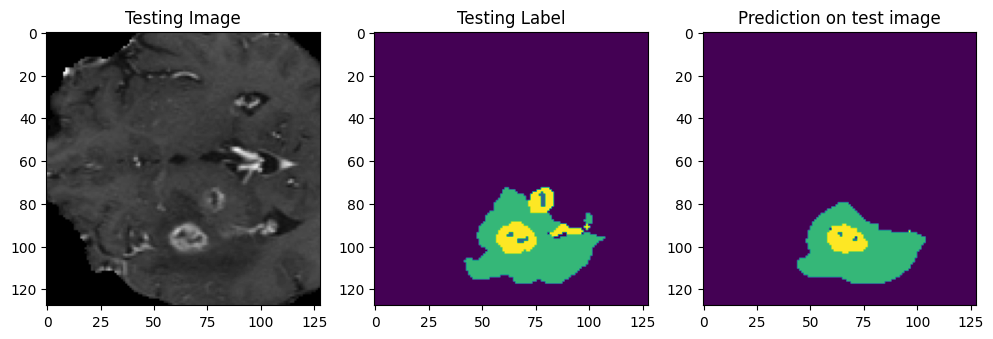

In [ ]:
img_num = 100

test_img = np.load("/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/input_data_128/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_modelu.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))


#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

In [ ]:
from keras.models import load_model
my_modeler = load_model('/content/drive/MyDrive/archive (11)/ufnew_newbrats_3d.hdf5',
                      compile=False)

In [1]:
import numpy as np

# if your model is saved as only a .h5 file
MODEL_LOCATION ='pf3new_newbrats_3d.hdf5'

# or if your model is saved as 2 files: model as a .json file, and weights as a .h5 file
JSON_LOCATION = ''
WEIGHTS_LOCATION = ''

In [2]:
if MODEL_LOCATION!='': #if your model is saved as a .h5 file only
    from keras.models import load_model
    model = load_model(MODEL_LOCATION,compile=False) #load the model
    print("loaded model from MODEL_LOCATION")

2023-07-26 11:53:00.963920: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


loaded model from MODEL_LOCATION


In [4]:
import tensorflow as tf

def convert_h5_to_aws(loaded_model):
    """
    given a pre-trained keras model, this function converts it to a TF protobuf format
    and saves it in the file structure which aws expects
    """  
    from tensorflow.python.saved_model import builder
    from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
    from tensorflow.python.saved_model import tag_constants
    
    # Disable eager execution to use certain TensorFlow functionalities
    tf.compat.v1.disable_eager_execution()

    # This is the file structure which AWS expects. Cannot be changed. 
    model_version = '1'
    export_dir = 'export/Servo/' + model_version
    
    # Build the Protocol Buffer SavedModel at 'export_dir'
    builder = builder.SavedModelBuilder(export_dir)
    
    # Create prediction signature to be used by TensorFlow Serving Predict API
    signature = predict_signature_def(
        inputs={"inputs": loaded_model.input}, outputs={"score": loaded_model.output})
    
    from keras import backend as K
    with K.get_session() as sess:
        # Save the meta graph and variables
        builder.add_meta_graph_and_variables(
            sess=sess, tags=[tag_constants.SERVING], signature_def_map={"serving_default": signature})
        builder.save()
    
    #create a tarball/tar file and zip it
    import tarfile
    with tarfile.open('model.tar.gz', mode='w:gz') as archive:
        archive.add('export', recursive=True)
        
convert_h5_to_aws(model)


INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: export/Servo/1/saved_model.pb


In [5]:
import sagemaker

sagemaker_session = sagemaker.Session()
inputs = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='model')

In [6]:
print("Bucket name is:")
sagemaker_session.default_bucket()

Bucket name is:


'sagemaker-us-east-1-075921637588'

In [7]:
!touch train.py

In [8]:
import boto3, re
from sagemaker import get_execution_role

# the (default) IAM role you created when creating this notebook
role = get_execution_role()

# Create a Sagemaker model (see AWS console>SageMaker>Models)
from sagemaker.tensorflow.model import TensorFlowModel
sagemaker_model = TensorFlowModel(model_data = 's3://' + sagemaker_session.default_bucket() + '/model/model.tar.gz',
                                  role = role,
                                  framework_version = '1.12',
                                  entry_point = 'train.py')

In [9]:
# Deploy a SageMaker to an endpoint
predictor = sagemaker_model.deploy(initial_instance_count=1,
                                   instance_type='ml.m4.xlarge')

-----!

In [10]:
# What is our endpoint called?
endpoint = predictor.endpoint
endpoint

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


'sagemaker-tensorflow-serving-2023-07-26-11-59-14-066'

In [24]:
import boto3

# Replace 'endpoint_name' with the name of your SageMaker endpoint
endpoint_name = 'sagemaker-tensorflow-serving-2023-07-26-11-59-14-066'

# Create a boto3 session to interact with SageMaker
boto3_session = boto3.Session()

# Use the boto3 session to create the SageMaker client
sagemaker_client = boto3_session.client('sagemaker')

try:
    # Describe the SageMaker endpoint to get information, including the region
    response = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
    
    # Get the endpoint ARN from the response
    endpoint_arn = response['EndpointArn']
    
    # Extract the region from the ARN
    region = endpoint_arn.split(':')[3]
    
    print(f"The region of the endpoint '{endpoint_name}' is: {region}")

except sagemaker_client.exceptions.ResourceNotFound:
    print(f"Endpoint '{endpoint_name}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")


The region of the endpoint 'sagemaker-tensorflow-serving-2023-07-26-11-59-14-066' is: us-east-1


In [30]:
pip install --upgrade boto3 botocore


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 115.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.29.157
    Uninstalling botocore-1.29.157:
      Successfully uninstalled botocore-1.29.157
  Attempting uninstall: boto3
    Found existing installation: boto3 1.26.157
    Uninstalling boto3-1.26.157:
      Successfully uninstalled boto3-1.26.157
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.27.157 requires botocore==1.29.157, but you have botocore 1.31.11 which is incompatible.
sagemaker 2.167.0 requires PyYAML==6.0, but you have pyyaml 5.4.1 which is incompatible.
Note: you may need to restart the kernel to use updated 

In [ ]:
import numpy as np
from sagemaker.tensorflow.model import TensorFlowPredictor
import boto3
from botocore import UNSIGNED
from botocore.config import Config
from matplotlib import pyplot as plt

# Load the test image in numpy format
test_img = np.load("image_130.npy")

# Create a custom botocore session with no credentials and disable SSL verification
botocore_session = boto3.session.Session(region_name='us-west-2')._session
botocore_session.get_component('credential_provider').insert_before('assume-role', 'static', 
    **{"sagemaker": {"arn:aws:sagemaker:us-east-1:075921637588:endpoint/sagemaker-tensorflow-serving-2023-07-26-11-59-14-066"}})
botocore_session.user_agent_name = None

# Use the custom botocore session to create the SageMaker session
sagemaker_session = boto3.Session(botocore_session=botocore_session)

# Define the endpoint name
endpoint = 'sagemaker-tensorflow-serving-2023-07-26-11-59-14-066'

# Create a predictor object for the SageMaker endpoint
predictor = TensorFlowPredictor(endpoint, sagemaker_session)

